In [1]:
%matplotlib inline

In [2]:
import logging

In [3]:
logging.basicConfig(level=logging.INFO)

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.metrics import f1_score

In [6]:
import matplotlib.pyplot as plt

In [7]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

# Load dataset

In [15]:
nb_folds = 5
fold_number = 0
models = ['unet', 'tiramisu']
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [25]:
threshold = 0.3

In [16]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [17]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 0 - 34 images


In [18]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [19]:
images = np.stack(images)
masks = np.stack(masks)

In [20]:
images.shape, masks.shape

((34, 500, 500, 3), (34, 500, 500))

# Load predictions 

In [21]:
predictions = []
for model in models:
    filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
    _, model_predictions = load_pickle(filename)
    
    predictions.append(model_predictions)

In [22]:
[p.shape for p in predictions]

[(34, 500, 500), (34, 500, 500)]

In [26]:
predictions_masks = []
for model_predictions in predictions:
    model_predictions_mask = np.zeros_like(model_predictions)
    model_predictions_mask[model_predictions>threshold] = 1
    
    predictions_masks.append(model_predictions_mask)

# Plot predictions

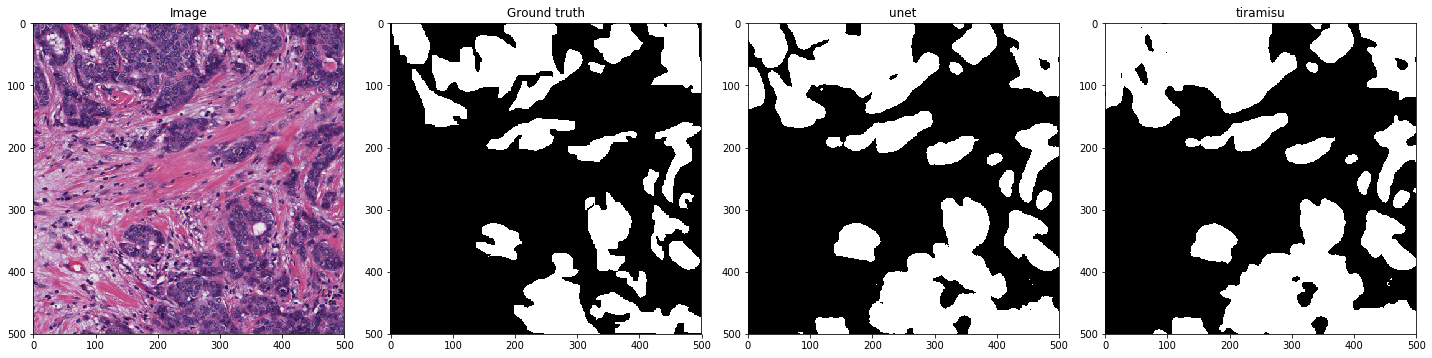

In [27]:
i = 4

fig, (ax_image, ax_groud_truth, *ax_models) = plt.subplots(1, 2 + len(models), figsize=(5 * (2 + len(models)),5))

ax_image.imshow(images[i])
ax_groud_truth.imshow(masks[i], cmap='gray')

ax_image.set_title('Image')
ax_groud_truth.set_title('Ground truth')

for ax, model, model_predictions in zip(ax_models, models, predictions_masks):
    ax.imshow(model_predictions[i], cmap='gray')
    ax.set_title(model)

fig.tight_layout()

# Get score

In [28]:
for model, model_predictions_masks in zip(models, predictions_masks):
    score = topcoder_metric(masks, model_predictions_masks)
    print(model, score)

unet 876705.935284
tiramisu 858917.407596


In [29]:
threshold_data = []
for model, model_predictions in zip(models, predictions):
    for tr in np.arange(0.1, 1.0, 0.1):
        predictions_mask = np.zeros_like(model_predictions)
        predictions_mask[model_predictions>tr] = 1

        score = topcoder_metric(masks, predictions_mask)

        threshold_data.append({'model':model, 'threshold': tr, 'score': score})

In [30]:
threshold_data = pd.DataFrame(threshold_data)

In [31]:
threshold_data

,model,score,threshold
0,unet,819513.797262,0.1
1,unet,861432.502688,0.2
2,unet,876705.935284,0.3
3,unet,880066.102236,0.4
4,unet,875798.372165,0.5
5,unet,863066.835270,0.6
6,unet,839107.182630,0.7
7,unet,794990.916216,0.8
8,unet,701274.056545,0.9
9,tiramisu,808928.506846,0.1


In [32]:
threshold_data.groupby('model').max()

,score,threshold
model,,
tiramisu,866173.367099,0.9
unet,880066.102236,0.9


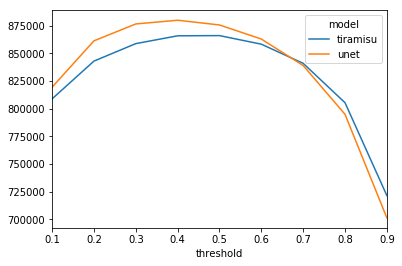

In [33]:
pd.pivot_table(threshold_data, values='score', columns='model', index='threshold').plot()

# Get scores

In [8]:
threshold = 0.3

In [20]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR
patch_size_train = 0
patch_size_predict = 0
nb_folds = 5

In [21]:
fold_number = 0
model = 'unet'
use_dice = False
use_tta = True

In [26]:
print(f'fold_number\tmodel\tuse_dice\tuse_tta\tscore')
for fold_number in range(nb_folds):
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    masks = [dataset[i][1] for i in range(len(dataset))]
    masks = np.stack(masks)

    for model in ['unet', 'tiramisu']:
        for use_dice in [True, False]:
            for use_tta in [True, False]:
                filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
                _, model_predictions = load_pickle(filename)
                model_predictions_mask = np.zeros_like(model_predictions)
                model_predictions_mask[model_predictions>threshold] = 1

                score = topcoder_metric(masks, model_predictions_mask)
                
                print(f'{fold_number}\t{model}\t{use_dice}\t{use_tta}\t{score}')

INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 0 - 34 images


fold_number	model	use_dice	use_tta	score
0	unet	True	True	880296.2983199764
0	unet	True	False	879082.3608641602
0	unet	False	True	876705.9352839272
0	unet	False	False	871963.9138677442
0	tiramisu	True	True	871646.1399881272
0	tiramisu	True	False	871002.9611850276
0	tiramisu	False	True	858917.407596231


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 1 - 34 images


0	tiramisu	False	False	858909.9182531321
1	unet	True	True	854411.1800713823
1	unet	True	False	851723.6212241593
1	unet	False	True	856706.2585397591
1	unet	False	False	856226.7231921208
1	tiramisu	True	True	847962.4812796472
1	tiramisu	True	False	846717.742873179
1	tiramisu	False	True	850128.8888601213


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 2 - 34 images


1	tiramisu	False	False	849249.9758058421
2	unet	True	True	885639.3877856745
2	unet	True	False	882586.2812354979
2	unet	False	True	890275.1334797489
2	unet	False	False	886704.8319538569
2	tiramisu	True	True	871932.6451349544
2	tiramisu	True	False	870525.9261632176
2	tiramisu	False	True	875182.968817903


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 3 - 33 images


2	tiramisu	False	False	875846.7841103642
3	unet	True	True	850596.2587184905
3	unet	True	False	845872.5934331084
3	unet	False	True	860192.7604549597
3	unet	False	False	858295.19341318
3	tiramisu	True	True	838256.1879007441
3	tiramisu	True	False	837854.8819733859
3	tiramisu	False	True	853546.3286857468


INFO:root:Data: PathologicalImagesDatasetMode.Val, fold 4 - 33 images


3	tiramisu	False	False	852130.1852985353
4	unet	True	True	851720.2798573358
4	unet	True	False	849942.5004859037
4	unet	False	True	851497.6883357535
4	unet	False	False	847987.7642988913
4	tiramisu	True	True	840776.7778698769
4	tiramisu	True	False	839170.9547945105
4	tiramisu	False	True	835975.3887574039
4	tiramisu	False	False	835284.8472109218
